# EC model performance v1

This version changes from v0 in the following ways:

1. Compare a year's risk model outputs against the NEXT year's ILI data, in order to avoid accounting for mitigated ILI problems of the same year when comparing agianst risk model outputs.
2. Instead of Risk_LOF values, use `S_EC` (external corrosion score) and `af_EC` (adjustment factor) as the risk score of comparisons.
3. Break out performance measurement by route types.

In [1]:
# Plotting and math imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

import pandas as pd

from datetime import datetime
from typing import List, Optional, Dict, Tuple

from scipy import stats

In [191]:
%load_ext autoreload
# auto-reload code changes
%autoreload 2  

from EC_model_performance import (
    FAILURE_PRESSURE_FIELDS,
    CALCULATED_RISK_FIELDS,
    LOCATION_FIELDS,
    STATIONING_VARS,
    VOLUMETRIC_LOSS_FIELDS,
    load_source_files,
    standardize_column_names_inplace,
    sanity_check_ILI_mileage_from_stationing,
    check_null_stationing,
    calculate_ILI_mileage_from_dataset_MP,
    sanitize_relevant_fields_inplace,
    sanity_check_stationing,
    do_segment_level_aggregation,
    get_route_types,
    augment_dataframe_inplace,
    make_performance_plot,
    convert_numeric_cols,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
from typing import NamedTuple

class SourceInfo(NamedTuple):
    ILI_csv_name: str
    spatial_joined_csv_name: str

dir_name = r"C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\processed_data"
source_info_2020 = SourceInfo(
    ILI_csv_name="cleaned_ILI_2021.csv",
    spatial_joined_csv_name="SJ_target=ILI2021_join=EC_spatialized_to_Pipesegment2020.csv"
)
source_info_2021 = SourceInfo(
    ILI_csv_name="cleaned_ILI_2022.csv",
    spatial_joined_csv_name="SJ_target=ILI2022_join=EC_spatialized_to_Pipesegment2021.csv"
)
source_info_2022 = SourceInfo(
    ILI_csv_name="cleaned_ILI_2023.csv",
    spatial_joined_csv_name="SJ_target=ILI2023_join=EC_spatialized_to_Pipesegment2022.csv"
)

In [162]:
figure_dir =  r"C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\EC_performance_figs"

# 2020

In [12]:
ILI_headers, master_dataset_2020 = load_source_files(
    dir_for_year=dir_name,
    cleaned_ILI_csv_fname=source_info_2020.ILI_csv_name,
    ILI_ECLOF_Pipesegment_joined_fname=source_info_2020.spatial_joined_csv_name
)

ILI data has 311799 rows
ILI_headers:
['Vendor', 'Source', 'Route', 'Route_NoPrefix', 'MP1', 'MP2', 'Year', 'ILI Project Name', 'ML Survey Date', 'Alignment Comment', 'Joint / US GW Number', 'ILI Survey Distance (ft)', 'Joint Length (ft)', 'From U/S GW (ft)', 'To D/S GW (ft)', 'Identification', 'Comment', 'Tool Speed (mph)', 'WT (in)', 'SMYS (PSI)', 'MAOP (PSI)', 'OD (in)', 'Longseam Visible', 'Seam Pos.', 'Depth (%)', 'Depth* (with tool tolerances)', 'OD Reduction (%)', 'Length (in)', 'Width (in)', "O'clock", 'Internal', 'Bend Radius (D)', 'Bend Angle (degrees)', 'Bend Direction', 'POF Category', 'Associated Tool Tolerance', 'Anomaly ID', 'Estimated Failure Pressure (Pf)', 'Pf/MAOP', 'Pf* (with tool tolerances)', 'Pf*/MAOP', 'TotalBend Strain', 'Bend - Vert Strain Component', 'Bend - Horiz Strain Component', 'Internal Dent Strain', 'External Dent Strain', 'Easting', 'Northing', 'Latitude', 'Longitude', 'Elevation', 'U/S Reference', 'Dist. To U/S Ref [ft]', 'D/S Reference', 'Dist. To D

In [13]:
master_dataset_2020 = standardize_column_names_inplace(master_dataset_2020)

In [20]:
# Expect 958.37 miles from 2021 ILI
unique_segments, ILI_milesage_2021 = sanity_check_ILI_mileage_from_stationing(master_dataset_2020)

Automatic pdb calling has been turned ON
Found 864.551 miles of ILI data from stationing


In [21]:
MP_ILI_mileage_2021 = calculate_ILI_mileage_from_dataset_MP(master_dataset_2020)

ILI mileage calculated from MP markers = 867.545 miles


So for 2021, anomalies entires were pretty uniformly distributed along the different segments.

In [153]:
df_no_null_stationing_2020, unique_segments, ILI_mileage_2021 = check_null_stationing(master_dataset_2020)
df_filtered_performance_2020 = sanitize_relevant_fields_inplace(df_no_null_stationing_2020)

Found 17 routes with null stationing:
['L-DREG4327' 'DFM-0837-01' 'DFM-1601-09' 'DFM-1611-03' 'DFM-8805-03'
 'L-002' 'L-021D' 'L-050A-1' 'L-057A' 'L-109' 'L-118A' 'L-118F' 'L-132A'
 'L-177A' 'L-210A' 'L-DREG4180' 'L-X6511']
Rows with location fields with null values:
----
route                      0
beginstationseriesid    4582
beginstationnum         4582
endstationseriesid      4582
endstationnum           4582
dtype: int64
Droppiong these rows
Found 864.551 miles of ILI data from stationing
225983/307217 rows with correct stationing have 0 failure pressures (73.558%). Fixing them
After fixing 0 failure pressure fields:
    Estimated Failure Pressure (Pf)  Pf/MAOP  Pf* (with tool tolerances)  \
0                              NaN      NaN                         NaN   
1                              NaN      NaN                         NaN   
2                              NaN      NaN                         NaN   
3                              NaN      NaN                         

C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\EC_model_performance.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_dataset_no_null_stationing[


6.452% of all identifications has only 1 occurence
Total 26674 manufacturing Identifications
Total 307214 Identifications
 8.683% of identifications are manufacturing related
Total 280540 non-manufacturing identifications
62711 / 280540 non-manufacturing rows are EC-related (22.354%).
After filtering, rows with NA in failure pressure fields still exist:
       Estimated Failure Pressure (Pf)  Pf/MAOP  Pf* (with tool tolerances)  \
47823                              NaN      NaN                         NaN   
48072                              NaN      NaN                         NaN   
48182                              NaN      NaN                         NaN   
48352                              NaN      NaN                         NaN   
48849                              NaN      NaN                         NaN   

       Pf*/MAOP  EC_LOF_Leak  EC_LOF_Rupture      S_EC     af_EC  route  \
47823       NaN          0.0        0.000036  5.973426  2.450655  L-131   
48072       NaN    

C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\EC_corrosion_stats.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ILI_df["Identification"] = filtered_ILI_df["Identification"].astype(str).apply(lambda x: x.strip()).apply(lambda x: x.lower())


In [154]:
(
    unique_segments_2020,
    num_segments_with_multiple_LOF_Leak_2020,
    num_segments_with_multiple_LOF_Rupture_2020
) = sanity_check_stationing(df_filtered_performance_2020)

ILI data is mapped to 7010 unique risk-model dynamic pipe segments
Number of dynamic segments with multiple LOF leak=0, with multiple LOF rupture=0


In [155]:
df_filtered_performance_2020 = augment_dataframe_inplace(df_filtered_performance_2020)

C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\EC_model_performance.py:359: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_performance_df["ln_EC_LOF_Leak"][has_nonzero_LOF_Leak] = np.log(
C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\EC_model_performance.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_performance_df["ln_EC_LOF_Rupture"][has_nonzero_LOF_Rupture] = np.log(
C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\EC_model_performance.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

In [158]:
dict_filtered_performance_df_aggregated_2020 = do_segment_level_aggregation(df_filtered_performance_2020)

DFM lines found: ['DFM-1615-04']
DREG lines found: []
SP lines found: ['L-SP3']
Xtie lines found: []
Backbone lines found: ['L-300A' 'L-303']
Numbered lines found: ['L-021G' 'L-101' 'L-108' 'L-131' 'L-132' 'L-132A' 'L-153' 'L-191-1'
 'L-210B']


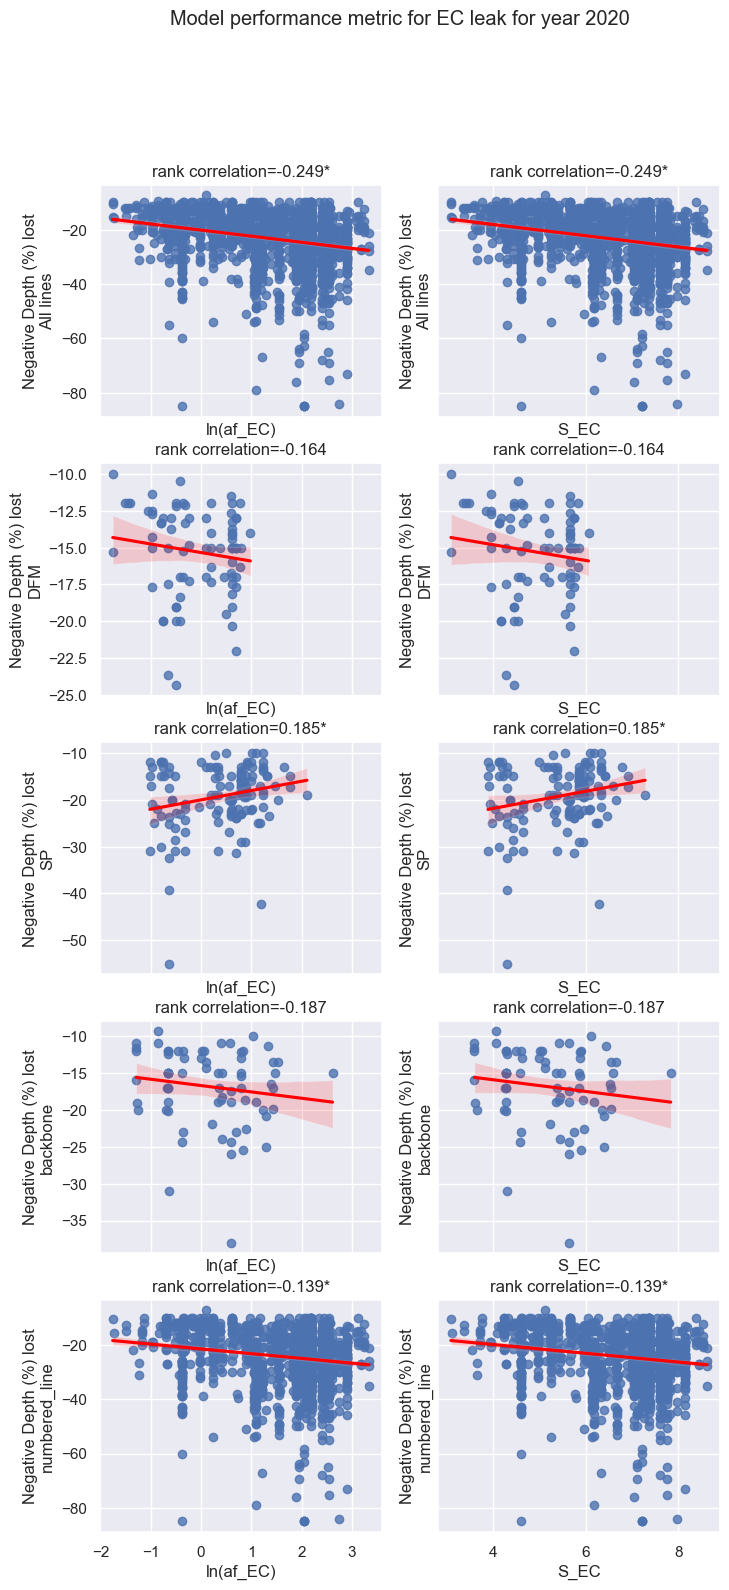

In [163]:
fig, axes = make_performance_plot(
    dict_filtered_performance_df_aggregated_2020,
    suptitle_postfix=" for year 2020",
    risk_output_type="leak",
)
plt.savefig(f"{figure_dir}/leak_2020.png")

DFM lines found: []
DREG lines found: []
SP lines found: ['L-SP3']
Xtie lines found: []
Backbone lines found: ['L-300A' 'L-300B' 'L-303' 'L-400']
Numbered lines found: ['L-108' 'L-131' 'L-210B']


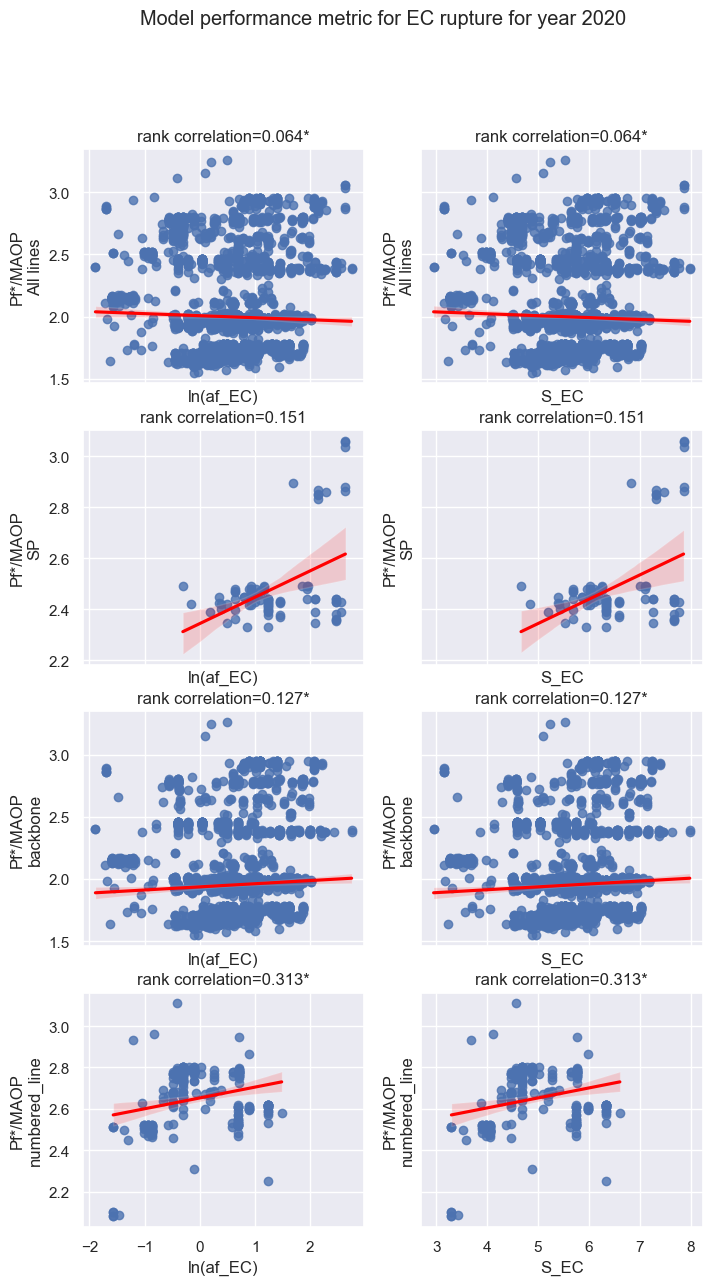

In [164]:
fig, axes = make_performance_plot(
    dict_filtered_performance_df_aggregated_2020,
    suptitle_postfix=" for year 2020",
    risk_output_type="rupture",
)
plt.savefig(f"{figure_dir}/rupture_2020.png")

# 2021

In [167]:
ILI_headers, master_dataset_2021 = load_source_files(
    dir_for_year=dir_name,
    cleaned_ILI_csv_fname=source_info_2021.ILI_csv_name,
    ILI_ECLOF_Pipesegment_joined_fname=source_info_2021.spatial_joined_csv_name
)

ILI data has 111969 rows
ILI_headers:
['Vendor', 'Source', 'Route', 'Route_NoPrefix', 'MP1', 'MP2', 'Year', 'ILI Project Name', 'ML Survey Date', 'Alignment Comment', 'Joint / US GW Number', 'ILI Survey Distance (ft)', 'Joint Length (ft)', 'From U/S GW (ft)', 'To D/S GW (ft)', 'Identification', 'Comment', 'Tool Speed (mph)', 'WT (in)', 'SMYS (PSI)', 'MAOP (PSI)', 'OD (in)', 'Longseam Visible', 'Seam Pos.', 'Depth (%)', 'Depth* (with tool tolerances)', 'OD Reduction (%)', 'Length (in)', 'Width (in)', "O'clock", 'Internal', 'Bend Radius (D)', 'Bend Angle (degrees)', 'Bend Direction', 'POF Category', 'Associated Tool Tolerance', 'Anomaly ID', 'Estimated Failure Pressure (Pf)', 'Pf/MAOP', 'Pf* (with tool tolerances)', 'Pf*/MAOP', 'TotalBend Strain', 'Bend - Vert Strain Component', 'Bend - Horiz Strain Component', 'Internal Dent Strain', 'External Dent Strain', 'Easting', 'Northing', 'Latitude', 'Longitude', 'Elevation', 'U/S Reference', 'Dist. To U/S Ref [ft]', 'D/S Reference', 'Dist. To D

In [169]:
master_dataset_2021 = standardize_column_names_inplace(master_dataset_2021)

In [173]:
# Expect 368.48 miles from 2022 ILI
unique_segments, ILI_mileage_2022 = sanity_check_ILI_mileage_from_stationing(master_dataset_2021)
MP_ILI_mileage_2022 = calculate_ILI_mileage_from_dataset_MP(master_dataset_2021)

Found 268.786 miles of ILI data from stationing
ILI mileage calculated from MP markers = 368.480 miles


In [176]:
df_no_null_stationing_2021, unique_segments, ILI_mileage_2022 = check_null_stationing(master_dataset_2021)
if df_no_null_stationing_2021 is None:
    df_no_null_stationing_2021 = master_dataset_2021    

Found 0 routes with null stationing:
[]


In [177]:
df_filtered_performance_2021 = sanitize_relevant_fields_inplace(df_no_null_stationing_2021)

(
    unique_segments_2021,
    num_segments_with_multiple_LOF_Leak_2021,
    num_segments_with_multiple_LOF_Rupture_2021
) = sanity_check_stationing(df_filtered_performance_2021)

79200/111667 rows with correct stationing have 0 failure pressures (70.925%). Fixing them
After fixing 0 failure pressure fields:
    Estimated Failure Pressure (Pf)  Pf/MAOP  Pf* (with tool tolerances)  \
0                              NaN      NaN                         NaN   
1                              NaN      NaN                         NaN   
2                              NaN      NaN                         NaN   
3                              NaN      NaN                         NaN   
4                              NaN      NaN                         NaN   

   Pf*/MAOP   EC_LOF_Leak  EC_LOF_Rupture      S_EC     af_EC        route  \
0       NaN  1.154881e-07             0.0  3.373580  0.223554  DFM-1209-01   
1       NaN  1.154881e-07             0.0  2.598934  0.109531  DFM-1209-01   
2       NaN  1.154881e-07             0.0  2.598934  0.109531  DFM-1209-01   
3       NaN  1.154881e-07             0.0  2.598934  0.109531  DFM-1209-01   
4       NaN  1.154881e-07   

In [178]:
df_filtered_performance_2021 = augment_dataframe_inplace(df_filtered_performance_2021)
dict_filtered_performance_df_aggregated_2021 = do_segment_level_aggregation(df_filtered_performance_2021)

C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\EC_model_performance.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_performance_df["ln_EC_LOF_Leak"][has_nonzero_LOF_Leak] = np.log(
C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\EC_model_performance.py:367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_performance_df["ln_EC_LOF_Rupture"][has_nonzero_LOF_Rupture] = np.log(
C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\EC_model_performance.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

DFM lines found: []
DREG lines found: []
SP lines found: []
Xtie lines found: []
Backbone lines found: ['L-057B' 'L-300B' 'L-401']
Numbered lines found: ['L-021H' 'L-0617-06' 'L-101' 'L-105B' 'L-109' 'L-111A' 'L-114' 'L-118B'
 'L-119A' 'L-138' 'L-138C' 'L-138E' 'L-153' 'L-301G']


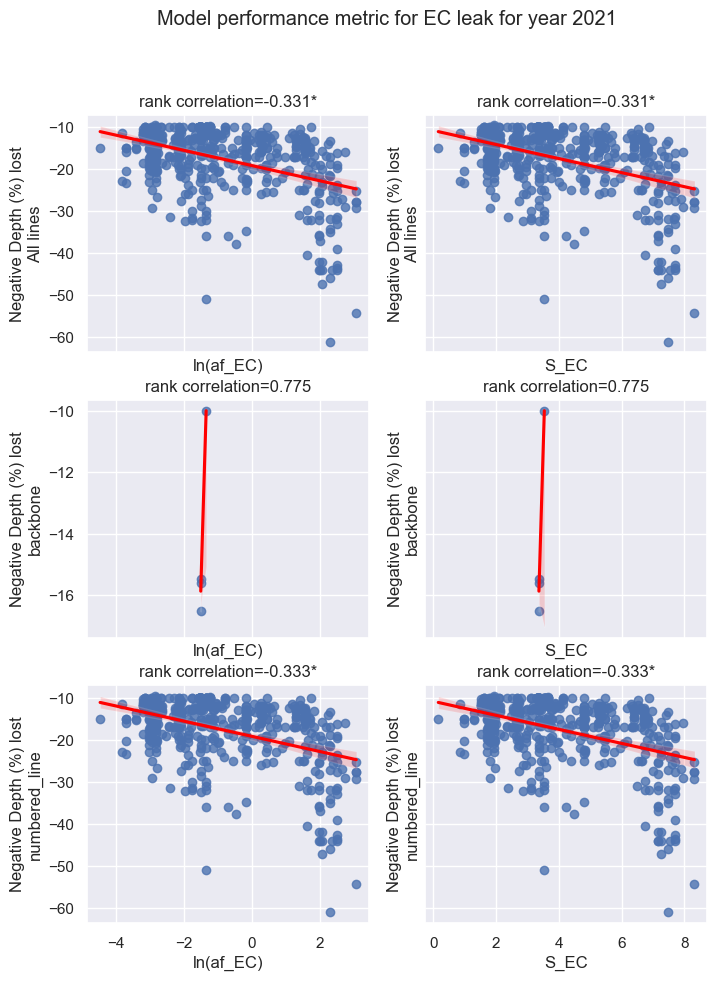

In [179]:
fig, axes = make_performance_plot(
    dict_filtered_performance_df_aggregated_2021,
    suptitle_postfix=" for year 2021",
    risk_output_type="leak",
)
plt.savefig(f"{figure_dir}/leak_2021.png")

DFM lines found: []
DREG lines found: []
SP lines found: []
Xtie lines found: []
Backbone lines found: ['L-057B' 'L-300B' 'L-401']
Numbered lines found: ['L-021H' 'L-101' 'L-111A' 'L-114' 'L-118B' 'L-119A' 'L-138C' 'L-301G'
 'L-310']


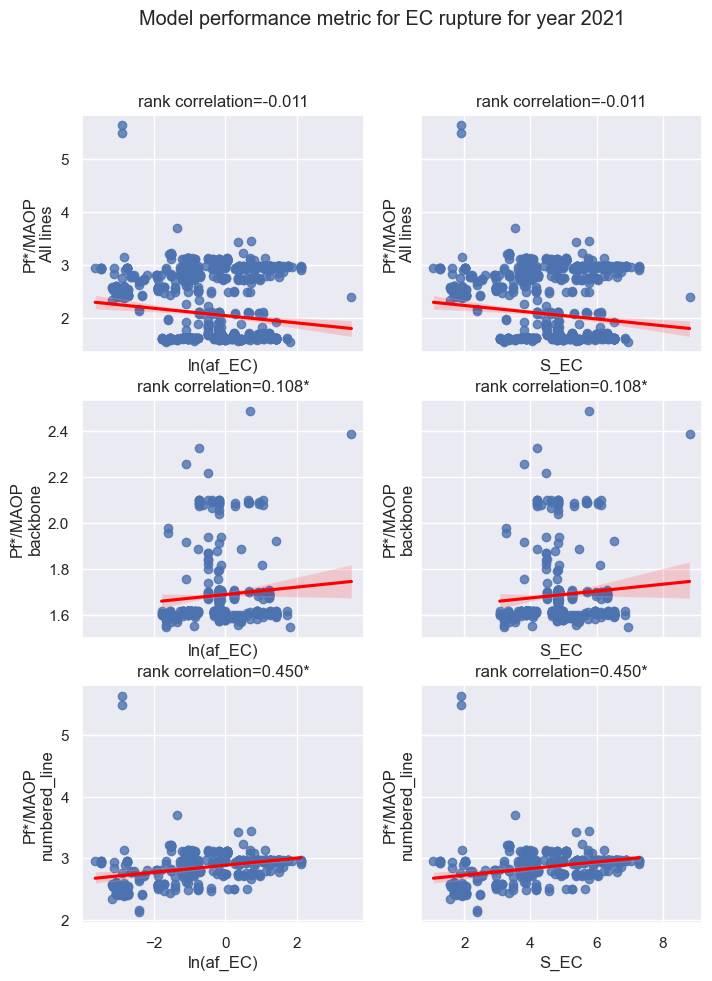

In [180]:
fig, axes = make_performance_plot(
    dict_filtered_performance_df_aggregated_2021,
    suptitle_postfix=" for year 2021",
    risk_output_type="rupture",
)
plt.savefig(f"{figure_dir}/rupture_2021.png")

# 2022

In [183]:
ILI_headers, master_dataset_2022 = load_source_files(
    dir_for_year=dir_name,
    cleaned_ILI_csv_fname=source_info_2022.ILI_csv_name,
    ILI_ECLOF_Pipesegment_joined_fname=source_info_2022.spatial_joined_csv_name
)

ILI data has 90887 rows
ILI_headers:
['Vendor', 'Source', 'Route', 'Route_NoPrefix', 'MP1', 'MP2', 'Year', 'ILI Project Name', 'ML Survey Date', 'Alignment Comment', 'Joint / US GW Number', 'ILI Survey Distance (ft)', 'Joint Length (ft)', 'From U/S GW (ft)', 'To D/S GW (ft)', 'Identification', 'Comment', 'Tool Speed (mph)', 'WT (in)', 'SMYS (PSI)', 'MAOP (PSI)', 'OD (in)', 'Longseam Visible', 'Seam Pos.', 'Depth (%)', 'Depth* (with tool tolerances)', 'OD Reduction (%)', 'Length (in)', 'Width (in)', "O'clock", 'Internal', 'Bend Radius (D)', 'Bend Angle (degrees)', 'Bend Direction', 'POF Category', 'Associated Tool Tolerance', 'Anomaly ID', 'Estimated Failure Pressure (Pf)', 'Pf/MAOP', 'Pf* (with tool tolerances)', 'Pf*/MAOP', 'TotalBend Strain', 'Bend - Vert Strain Component', 'Bend - Horiz Strain Component', 'Internal Dent Strain', 'External Dent Strain', 'Easting', 'Northing', 'Latitude', 'Longitude', 'Elevation', 'U/S Reference', 'Dist. To U/S Ref [ft]', 'D/S Reference', 'Dist. To D/

In [196]:
master_dataset_2022 = standardize_column_names_inplace(master_dataset_2022)
master_dataset_2022 = convert_numeric_cols(master_dataset_2022)

In [197]:
# Expect 147.39 miles from 2023 ILI
unique_segments, ILI_mileage_2023 = sanity_check_ILI_mileage_from_stationing(master_dataset_2022)
MP_ILI_mileage_2023 = calculate_ILI_mileage_from_dataset_MP(master_dataset_2022)

Found 141.798 miles of ILI data from stationing
ILI mileage calculated from MP markers = 157.741 miles


In [198]:
df_no_null_stationing_2022, unique_segments, ILI_mileage_2023 = check_null_stationing(master_dataset_2022)
if df_no_null_stationing_2022 is None:
    df_no_null_stationing_2022 = master_dataset_2022

Found 0 routes with null stationing:
[]


In [199]:
df_filtered_performance_2022 = sanitize_relevant_fields_inplace(df_no_null_stationing_2022)

(
    unique_segments_2022,
    num_segments_with_multiple_LOF_Leak_2022,
    num_segments_with_multiple_LOF_Rupture_2022
) = sanity_check_stationing(df_filtered_performance_2022)

0/88207 rows with correct stationing have 0 failure pressures (0.000%). Fixing them
After fixing 0 failure pressure fields:
    Estimated Failure Pressure (Pf)  Pf/MAOP  Pf* (with tool tolerances)  \
0                           2255.0     3.70                      2237.0   
1                              NaN      NaN                         NaN   
2                           2059.0     3.38                      2045.0   
3                              NaN      NaN                         NaN   
4                           2036.0     3.34                      2000.0   

   Pf*/MAOP   EC_LOF_Leak  EC_LOF_Rupture      S_EC     af_EC   route  \
0      3.67  9.007586e-07             0.0  4.093811  0.433974  L-021E   
1       NaN  9.007586e-07             0.0  4.093811  0.433974  L-021E   
2      3.35  1.447776e-06             0.0  4.214992  0.485215  L-021E   
3       NaN  1.447776e-06             0.0  4.214992  0.485215  L-021E   
4      3.28  9.007586e-07             0.0  3.243640  0.1983

In [200]:
# one time special data cleaning
df_filtered_performance_2020["Depth (%)"] = pd.to_numeric(df_filtered_performance_2020["Depth (%)"]) 
df_filtered_performance_2022 = augment_dataframe_inplace(df_filtered_performance_2022)
dict_filtered_performance_df_aggregated_2022 = do_segment_level_aggregation(df_filtered_performance_2022)

C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\EC_model_performance.py:377: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_performance_df["ln_EC_LOF_Leak"][has_nonzero_LOF_Leak] = np.log(
C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\EC_model_performance.py:383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_performance_df["ln_EC_LOF_Rupture"][has_nonzero_LOF_Rupture] = np.log(
C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\EC_model_performance.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

DFM lines found: []
DREG lines found: []
SP lines found: ['L-SP5']
Xtie lines found: []
Backbone lines found: []
Numbered lines found: ['L-021E' 'L-109' 'L-119C' 'L-138' 'L-210A' 'L-220']


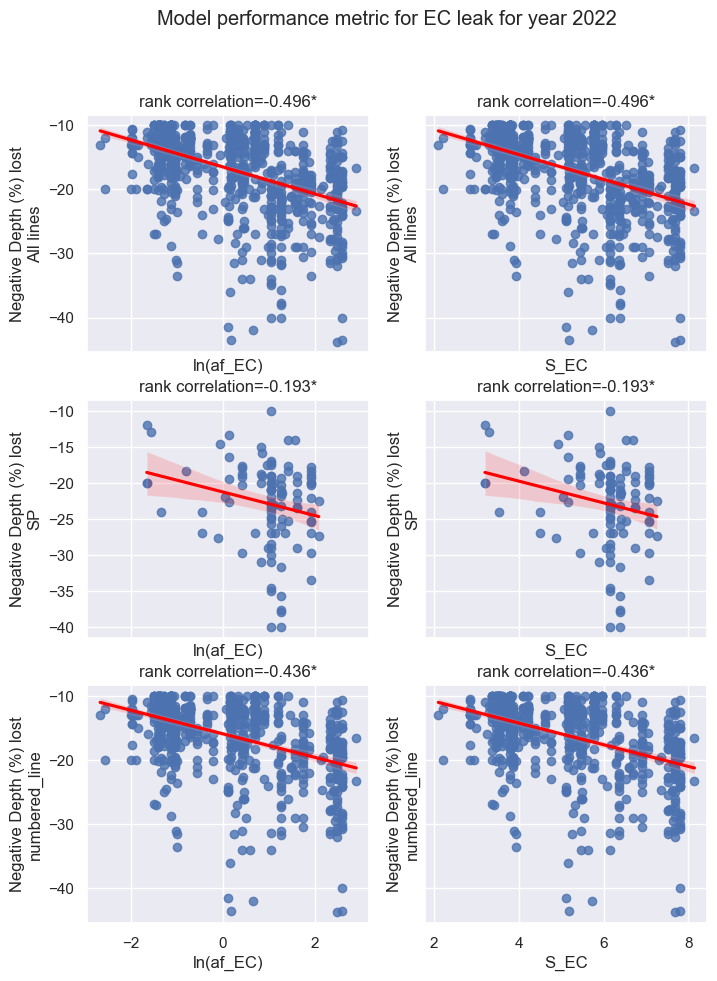

In [201]:
fig, axes = make_performance_plot(
    dict_filtered_performance_df_aggregated_2022,
    suptitle_postfix=" for year 2022",
    risk_output_type="leak",
)
plt.savefig(f"{figure_dir}/leak_2022.png")

DFM lines found: []
DREG lines found: []
SP lines found: ['L-SP5']
Xtie lines found: []
Backbone lines found: ['L-300B']
Numbered lines found: ['L-119C' 'L-210A' 'L-220']


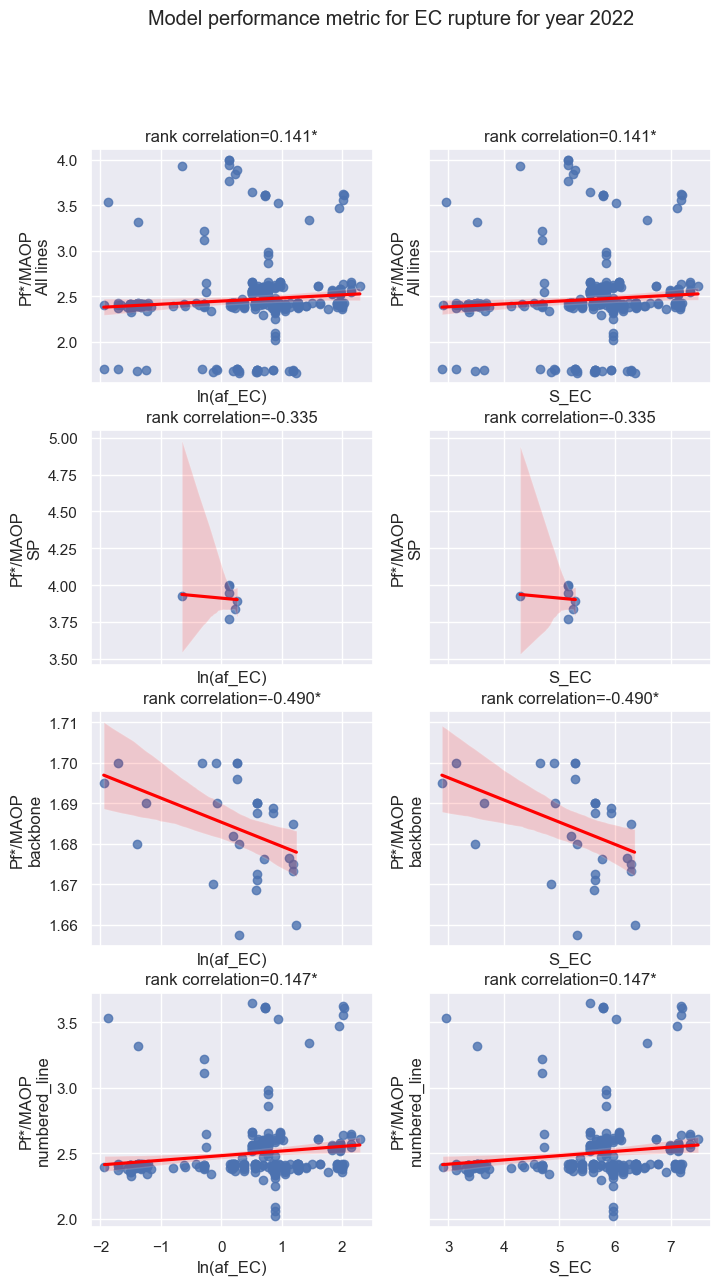

In [202]:
fig, axes = make_performance_plot(
    dict_filtered_performance_df_aggregated_2022,
    suptitle_postfix=" for year 2022",
    risk_output_type="rupture",
)
plt.savefig(f"{figure_dir}/rupture_2022.png")

# All years combined..

In [203]:
df_merged_mean_agg = pd.concat(
    [
        dict_filtered_performance_df_aggregated_2020["mean"],
        dict_filtered_performance_df_aggregated_2021["mean"],
        dict_filtered_performance_df_aggregated_2022["mean"],
    ]
)

DFM lines found: ['DFM-1615-04']
DREG lines found: []
SP lines found: ['L-SP3' 'L-SP5']
Xtie lines found: []
Backbone lines found: ['L-300A' 'L-303' 'L-057B' 'L-300B' 'L-401']
Numbered lines found: ['L-021G' 'L-101' 'L-108' 'L-131' 'L-132' 'L-132A' 'L-153' 'L-191-1'
 'L-210B' 'L-021H' 'L-0617-06' 'L-105B' 'L-109' 'L-111A' 'L-114' 'L-118B'
 'L-119A' 'L-138' 'L-138C' 'L-138E' 'L-301G' 'L-021E' 'L-119C' 'L-210A'
 'L-220']


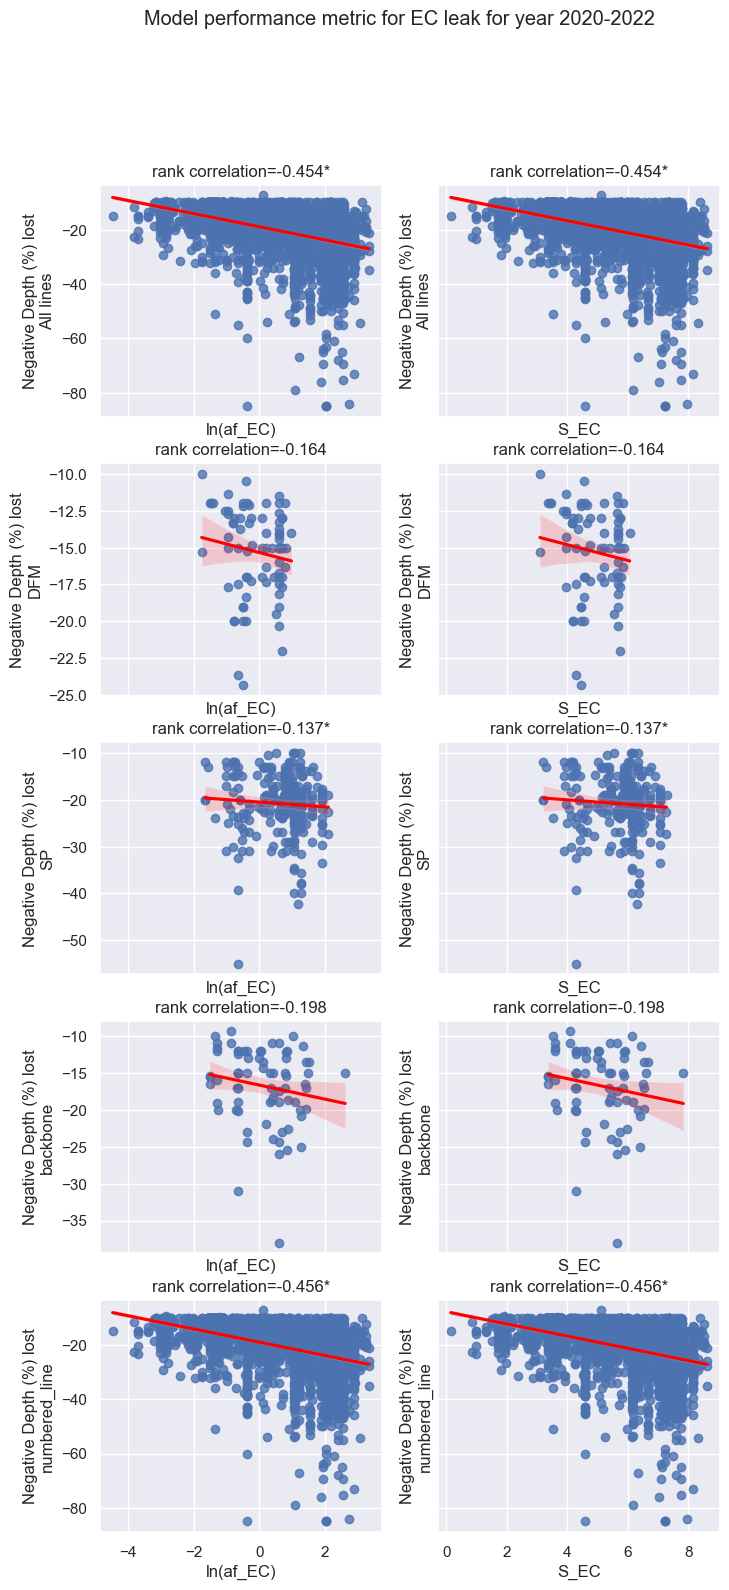

In [204]:
fig, axes = make_performance_plot(
    {"mean": df_merged_mean_agg},
    suptitle_postfix=" for year 2020-2022",
    risk_output_type="leak",
)
plt.savefig(f"{figure_dir}/leak_20202_to_2022.png")

DFM lines found: []
DREG lines found: []
SP lines found: ['L-SP3' 'L-SP5']
Xtie lines found: []
Backbone lines found: ['L-300A' 'L-300B' 'L-303' 'L-400' 'L-057B' 'L-401']
Numbered lines found: ['L-108' 'L-131' 'L-210B' 'L-021H' 'L-101' 'L-111A' 'L-114' 'L-118B'
 'L-119A' 'L-138C' 'L-301G' 'L-310' 'L-119C' 'L-210A' 'L-220']


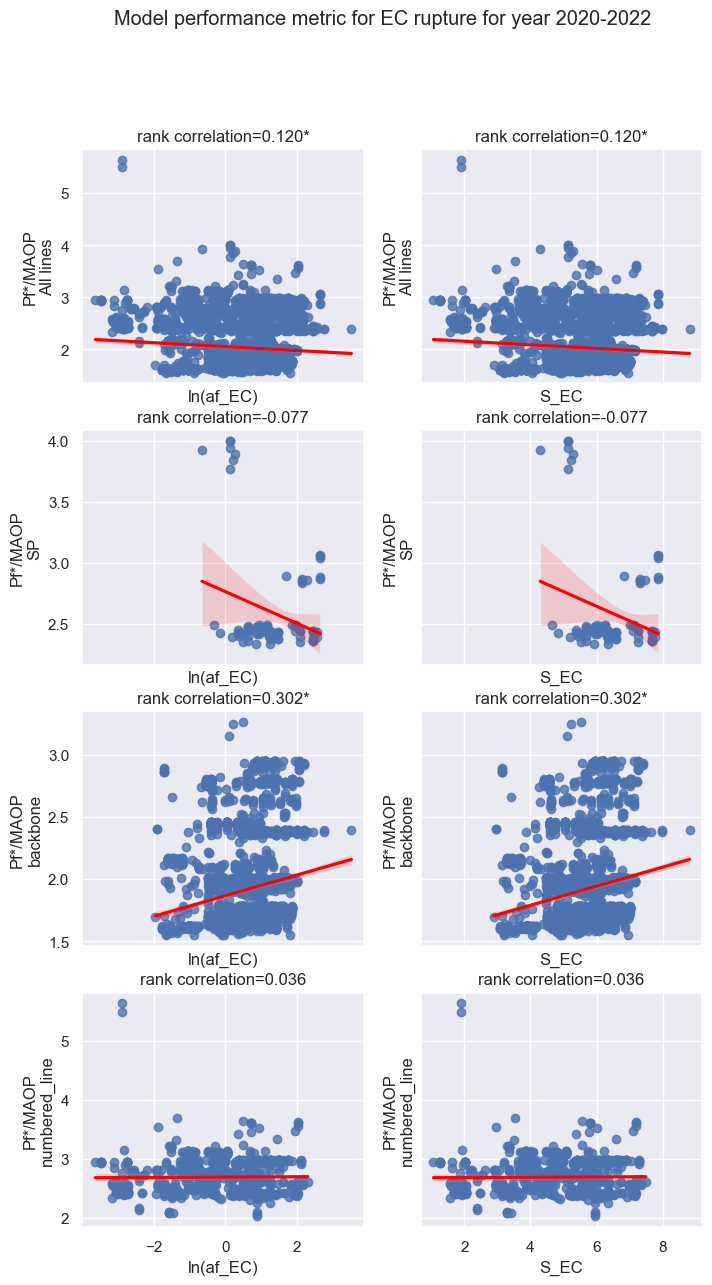

In [205]:
fig, axes = make_performance_plot(
    {"mean": df_merged_mean_agg},
    suptitle_postfix=" for year 2020-2022",
    risk_output_type="rupture",
)
plt.savefig(f"{figure_dir}/rupture_20202_to_2022.png")